In [10]:
import os
import glob

import functools
import numpy as np
import xarray as xr
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from fates_calibration.compile_LH_ensemble import annual_mean
from fates_calibration.FATES_calibration_constants import ILAMB_MODELS

In [11]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    account='P93300041',                         # Input your project ID here
    walltime='02:00:00',                         # Amount of wall time
    interface='ext')                             # Interface to use

cluster.scale(10)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45851 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45851/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45851/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:38239,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45851/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
archive_dir = '/glade/derecho/scratch/afoster/transient_ensemble/spinup/archive/ctsm51FATES_SP_sparsegrid_FATES_FIN_101/lnd/hist'

In [13]:
data_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE', 'QVEGT',
     'EFLX_LH_TOT', 'FSH', 'QRUNOFF', 'SOILWATER_10CM',
     'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'RAIN',
     'SNOW', 'H2OSNO', 'SNOWDP', 'TSA', 'landfrac', 'area']

data_vars_ctsm = ['FPSN', 'QVEGE', 'QVEGT',
     'EFLX_LH_TOT', 'FSH', 'QRUNOFF', 'SOILWATER_10CM',
     'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'RAIN',
     'SNOW', 'H2OSNO', 'SNOWDP', 'TSA', 'landfrac', 'area']

In [14]:
def preprocess(ds, varset):
    return ds[varset]

In [15]:
def get_map(ds, da):
    
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    out = np.zeros(sg.cclass.shape) + np.nan
    for c,(o,a) in enumerate(sg.rcent_coords):
        i = np.arange(400)[
            (abs(ds.grid1d_lat - a) < 0.1) &
            (abs(ds.grid1d_lon - o) < 0.1)]
        out[sg.cclass == c + 1] = i
    cclass = out.copy()
    cclass[np.isnan(out)] = 0

    sgmap = xr.Dataset()
    sgmap['cclass'] = xr.DataArray(cclass.astype(int), dims=['lat','lon'])
    sgmap['notnan'] = xr.DataArray(~np.isnan(out), dims=['lat','lon'])
    sgmap['lat'] = sg.lat
    sgmap['lon'] = sg.lon
    
    damap = da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()
    
    return damap

In [22]:
def get_ensemble(top_dir, data_vars):

    files = sorted(glob.glob(top_dir + "/*clm2.h0*.nc"))
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time',
                           preprocess=functools.partial(preprocess,
                                                        varset=data_vars),
                           parallel=True, autoclose=True)

    # fix time bug
    ds['time'] = xr.cftime_range(str(2005), periods=len(ds.time), freq='MS')
    ds = ds.sel(time=slice("2055-01-01", "2064-12-31"))
    ds['time'] = xr.cftime_range(str(2005), periods=12*10, freq='MS')

    # calculate some variables

    ds['GPP'] = ds['FATES_GPP']*ds['FATES_FRACTION']  # kg m-2 s-1
    ds['GPP'].attrs['units'] = ds['FATES_GPP'].attrs['units']
    ds['GPP'].attrs['long_name'] = ds['FATES_GPP'].attrs['long_name']

    ds['LAI'] = ds['FATES_LAI']*ds['FATES_FRACTION']  # m m-2 
    ds['LAI'].attrs['units'] = ds['FATES_LAI'].attrs['units']
    ds['LAI'].attrs['long_name'] = ds['FATES_LAI'].attrs['long_name']

    sh = ds.FSH
    le = ds.EFLX_LH_TOT
    energy_threshold = 20
    
    sh = sh.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    le = le.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    ds['EF'] = le/(le + sh)
    ds['EF'].attrs['units'] = 'unitless'
    ds['EF'].attrs['long_name'] = 'Evaporative fraction'

    ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS > 0)
    ds['ASA'].attrs['units'] = 'unitless'
    ds['ASA'].attrs['long_name'] = 'All sky albedo'

    ds['RLNS'] = ds.FLDS - ds.FIRE
    ds['RLNS'].attrs['units'] = 'W m-2'
    ds['RLNS'].attrs['long_name'] = 'surface net longwave radiation'

    ds['RN'] = ds.FLDS - ds.FIRE + ds.FSDS - ds.FSR
    ds['RN'].attrs['units'] = 'W m-2'
    ds['RN'].attrs['long_name'] = 'surface net radiation'

    ds['Temp'] = ds.TSA - 273.15
    ds['Temp'].attrs['units'] = 'degrees C'
    ds['Temp'].attrs['long_name'] = ds['TSA'].attrs['long_name']

    # GPP in kg/m2/yr
    gpp_ens = annual_mean(ds.GPP, 24*60*60).mean(dim='year')

    # LAI [m2/m2]
    lai_ens = annual_mean(ds.LAI, 1/365).mean(dim='year')

    # ET in W/m2
    lh_ens = annual_mean(ds.EFLX_LH_TOT, 1/365).mean(dim='year')

    # SH in W/m2
    sh_ens = annual_mean(ds.FSH, 1/365).mean(dim='year')

    # evaporative fraction [0-1]
    ef_ens = annual_mean(ds.EF, 1/365).mean(dim='year')

    # surface soil moisture
    sw_ens = annual_mean(ds.SOILWATER_10CM, 1/365).mean(dim='year')

    # albedo [0-1]
    alb_ens = annual_mean(ds.ASA, 1/365).mean(dim='year')

    #surface upward sw radiation
    fsr_ens = annual_mean(ds.FSR, 1/365).mean(dim='year')

    # surface net sw radiation
    fsa_ens = annual_mean(ds.FSA, 1/365).mean(dim='year')

    # surface upward longwave radiation
    fire_ens = annual_mean(ds.FIRE, 1/365).mean(dim='year')

    # surface net longwave radiation
    rlns_ens = annual_mean(ds.RLNS, 1/365).mean(dim='year')

    # surface net radiation
    rn_ens = annual_mean(ds.RN, 1/365).mean(dim='year')
    
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat', 'grid1d_lon']

    ensemble_ds = xr.merge([gpp_ens, lai_ens, lh_ens, sh_ens, ef_ens,
                            sw_ens, alb_ens, fsr_ens,
                           fsa_ens, fire_ens, rlns_ens, rn_ens])
    for extra in extras:
        ensemble_ds[extra] = ds0[extra]
    

    return ensemble_ds

In [17]:
def get_fates_original(file):
    
    ds = xr.open_dataset(file)
    
    ds['GPP'] = ds['FATES_GPP']*ds['FATES_FRACTION']  # kg m-2 s-1
    ds['GPP'].attrs['units'] = ds['FATES_GPP'].attrs['units']
    ds['GPP'].attrs['long_name'] = ds['FATES_GPP'].attrs['long_name']

    ds['LAI'] = ds['FATES_LAI']*ds['FATES_FRACTION']  # m m-2 
    ds['LAI'].attrs['units'] = ds['FATES_LAI'].attrs['units']
    ds['LAI'].attrs['long_name'] = ds['FATES_LAI'].attrs['long_name']

    sh = ds.FSH
    le = ds.EFLX_LH_TOT
    energy_threshold = 20
    
    sh = sh.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    le = le.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    ds['EF'] = le/(le + sh)
    ds['EF'].attrs['units'] = 'unitless'
    ds['EF'].attrs['long_name'] = 'Evaporative fraction'

    ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS > 0)
    ds['ASA'].attrs['units'] = 'unitless'
    ds['ASA'].attrs['long_name'] = 'All sky albedo'

    ds['RLNS'] = ds.FLDS - ds.FIRE
    ds['RLNS'].attrs['units'] = 'W m-2'
    ds['RLNS'].attrs['long_name'] = 'surface net longwave radiation'

    ds['RN'] = ds.FLDS - ds.FIRE + ds.FSDS - ds.FSR
    ds['RN'].attrs['units'] = 'W m-2'
    ds['RN'].attrs['long_name'] = 'surface net radiation'

    ds['Temp'] = ds.TSA - 273.15
    ds['Temp'].attrs['units'] = 'degrees C'
    ds['Temp'].attrs['long_name'] = ds['TSA'].attrs['long_name']

    # GPP in kg/m2/yr
    gpp_ens = annual_mean(ds.GPP, 24*60*60).mean(dim='year')

    # LAI [m2/m2]
    lai_ens = annual_mean(ds.LAI, 1/365).mean(dim='year')

    # ET in W/m2
    lh_ens = annual_mean(ds.EFLX_LH_TOT, 1/365).mean(dim='year')

    # SH in W/m2
    sh_ens = annual_mean(ds.FSH, 1/365).mean(dim='year')

    # evaporative fraction [0-1]
    ef_ens = annual_mean(ds.EF, 1/365).mean(dim='year')

    # surface soil moisture
    sw_ens = annual_mean(ds.SOILWATER_10CM, 1/365).mean(dim='year')

    # albedo [0-1]
    alb_ens = annual_mean(ds.ASA, 1/365).mean(dim='year')

    #surface upward sw radiation
    fsr_ens = annual_mean(ds.FSR, 1/365).mean(dim='year')

    # surface net sw radiation
    fsa_ens = annual_mean(ds.FSA, 1/365).mean(dim='year')

    # surface upward longwave radiation
    fire_ens = annual_mean(ds.FIRE, 1/365).mean(dim='year')

    # surface net longwave radiation
    rlns_ens = annual_mean(ds.RLNS, 1/365).mean(dim='year')

    # surface net radiation
    rn_ens = annual_mean(ds.RN, 1/365).mean(dim='year')
    
    ensemble_ds = xr.merge([gpp_ens, lai_ens, lh_ens, sh_ens, ef_ens,
                            sw_ens, alb_ens, fsr_ens,
                           fsa_ens, fire_ens, rlns_ens, rn_ens])

    return ensemble_ds

In [23]:
ds = get_ensemble(archive_dir, data_vars)

In [24]:
# whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/CLM5PPE/pyth/whit/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea  #km2

ds['biome'] = whittaker_ds.biome
ds['biome_name'] = whittaker_ds.biome_name

In [44]:
gpp = get_map(ds, ds.GPP).to_dataset(name='fates_updated')

In [26]:
gpp_fates = ds.GPP.to_dataset(name='fates_updated')

In [27]:
ilamb = xr.open_dataset('/glade/u/home/afoster/FATES_Calibration/observations/ILAMB_obs.nc')

In [28]:
ilamb_gpp = ilamb.where(ilamb.model.isin(ILAMB_MODELS['GPP'])).gpp.mean(dim='model').to_dataset(name='ilamb')

In [31]:
fates_orig = os.path.join('/glade/work/afoster/FATES_calibration/old_calib/configuration_testing/',
                          'ilamb_hist/grid_15/',
                          'ctsm51FATES_SP_OAAT_SatPhen_derecho_2000_FATES_factoral_grid_15.nc')

In [32]:
fates_orig_data = get_fates_original(fates_orig)

In [34]:
dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_bigleaf_fullgrid/lnd/hist'
ctsm_files = sorted([os.path.join(dir, f) for f in os.listdir(dir)])
ctsm = xr.open_mfdataset(ctsm_files, combine='nested', concat_dim='time',
                       preprocess=functools.partial(preprocess, varset=data_vars_ctsm),
                       parallel=True, autoclose=True)

In [35]:
ctsm['time'] = xr.cftime_range(str(2005), periods=len(ctsm.time), freq='MS')
ctsm = ctsm.sel(time=slice("2055-01-01", "2064-12-31"))
ctsm['time'] = xr.cftime_range(str(2005), periods=12*10, freq='MS')

In [36]:
ctsm['GPP_kgc_m2_s'] = ctsm.FPSN*1E-6*12.011/1000.0

In [37]:
ctsm_ann_gpp = annual_mean(ctsm['GPP_kgc_m2_s'], 24*60*60).mean(dim='year')

In [45]:
all = xr.merge([ilamb_gpp, fates_orig_data.GPP.to_dataset(name='fates_orig'), gpp, ctsm_ann_gpp.to_dataset(name='CTSM')])

In [46]:
all['updated_diff'] = all.fates_updated - all.ilamb
all['old_diff'] = all.fates_orig - all.ilamb
all['ctsm_diff'] = all.CTSM - all.ilamb
all['diff_change'] = np.abs(all.updated_diff) - np.abs(all.old_diff)
all['diff_change_CTSM'] = np.abs(all.updated_diff) - np.abs(all.ctsm_diff)

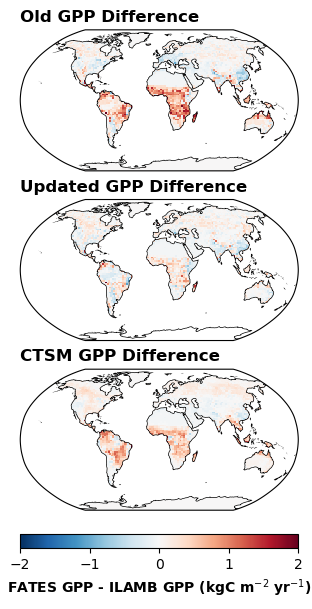

In [50]:
figure, axes = plt.subplots(ncols=1, nrows=3, figsize=(13, 6),
                                subplot_kw=dict(projection=ccrs.Robinson()),
                                layout='compressed')

axes[0].set_title('Old GPP Difference', loc='left', fontsize='large', fontweight='bold')
axes[0].coastlines()
axes[0].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
axes[0].pcolormesh(all.lon, all.lat, all.old_diff,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap='RdBu_r', vmin=-2, vmax=2)

axes[1].set_title('Updated GPP Difference', loc='left', fontsize='large', fontweight='bold')
axes[1].coastlines()
axes[1].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
pcm = axes[1].pcolormesh(all.lon, all.lat, all.updated_diff,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap='RdBu_r', vmin=-2, vmax=2)

axes[2].set_title('CTSM GPP Difference', loc='left', fontsize='large', fontweight='bold')
axes[2].coastlines()
axes[2].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
axes[2].pcolormesh(all.lon, all.lat, all.ctsm_diff,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap='RdBu_r', vmin=-2, vmax=2)



cbar = figure.colorbar(pcm, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('FATES GPP - ILAMB GPP (kgC m$^{-2}$ yr$^{-1}$)', size=10, fontweight='bold')
plt.savefig('updated_gpp.png')

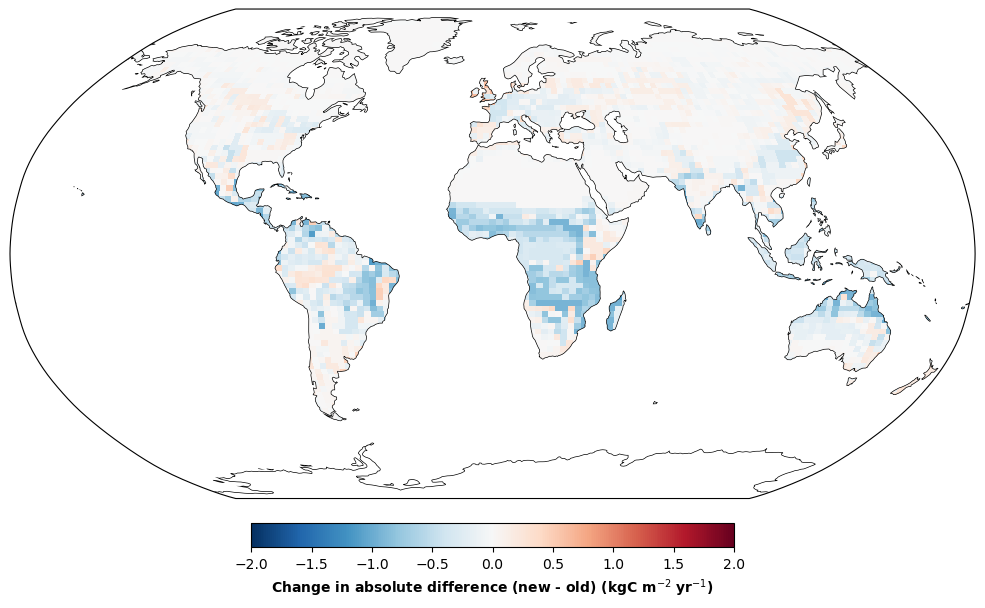

In [48]:
figure, ax = plt.subplots(figsize=(13, 6),
                                subplot_kw=dict(projection=ccrs.Robinson()),
                                layout='compressed')
ax.coastlines()
ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
pcm = ax.pcolormesh(all.lon, all.lat, all.diff_change,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap='RdBu_r', vmin=-2, vmax=2)
cbar = figure.colorbar(pcm, ax=ax, shrink=0.5, orientation='horizontal')
cbar.set_label('Change in absolute difference (new - old) (kgC m$^{-2}$ yr$^{-1}$)', size=10, fontweight='bold')
#plt.savefig('difference.png')

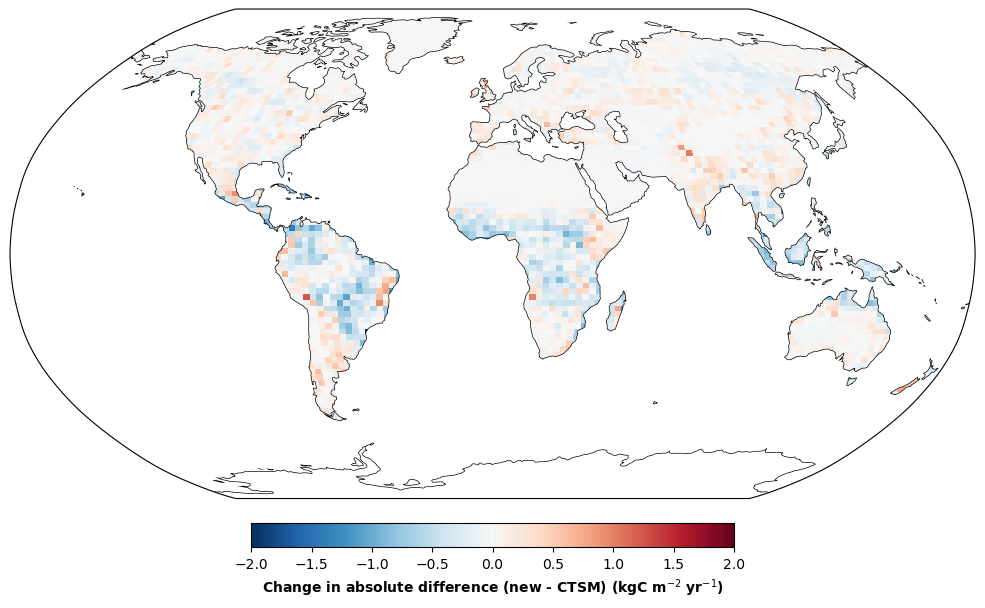

In [49]:
figure, ax = plt.subplots(figsize=(13, 6),
                                subplot_kw=dict(projection=ccrs.Robinson()),
                                layout='compressed')
ax.coastlines()
ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
pcm = ax.pcolormesh(all.lon, all.lat, all.diff_change_CTSM,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap='RdBu_r', vmin=-2, vmax=2)
cbar = figure.colorbar(pcm, ax=ax, shrink=0.5, orientation='horizontal')
cbar.set_label('Change in absolute difference (new - CTSM) (kgC m$^{-2}$ yr$^{-1}$)', size=10, fontweight='bold')